In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage5')

In [ ]:
ROI_dir = '/gscratch/fang/NARSAD/ROI'

### making ROI mask (lateral ROIs combined into 1 bilateral ROI)

BIDS Layout: ...sktop Drive/NARSAD/derivatives | Subjects: 102 | Sessions: 102 | Runs: 10


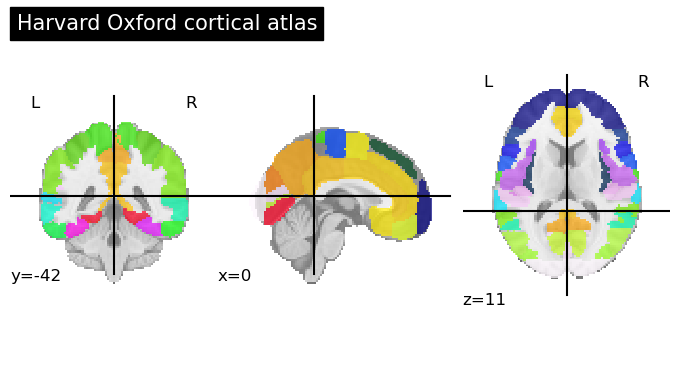

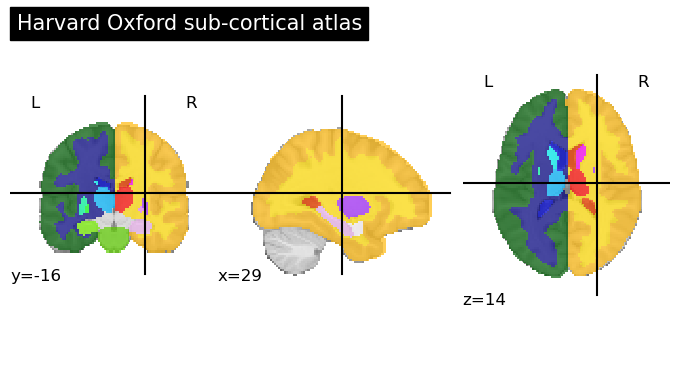

In [ ]:
import numpy as np
from nilearn import datasets
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

dataset_ho_cort = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split=False) #changing from bilateral to combined left/right
atlas_ho_cort_filename = dataset_ho_cort.filename
plotting.plot_roi(atlas_ho_cort_filename, title="Harvard Oxford cortical atlas")

dataset_ho_sub = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", symmetric_split=False)
atlas_ho_sub_filename = dataset_ho_sub.filename
plotting.plot_roi(atlas_ho_sub_filename, title="Harvard Oxford sub-cortical atlas")

layout = bids.BIDSLayout('/gscratch/fang/NARSAD/MRI/derivatives/fmriprep', validate=False,
                  config=['bids','derivatives'])
print(layout)

In [44]:
#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

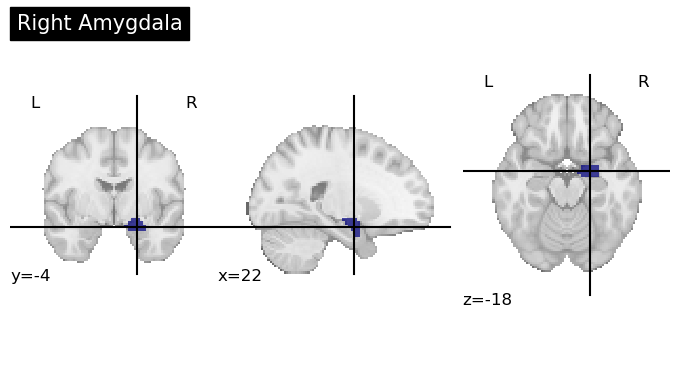

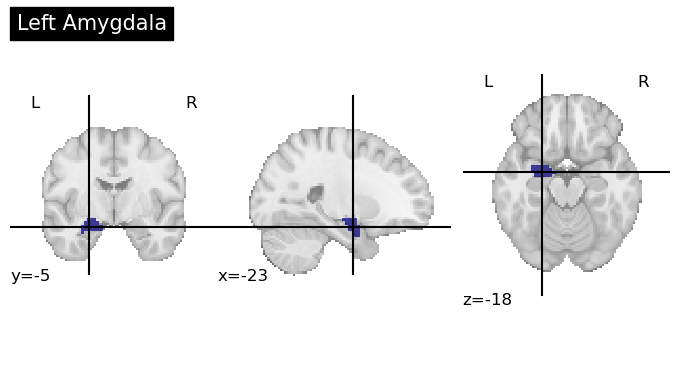

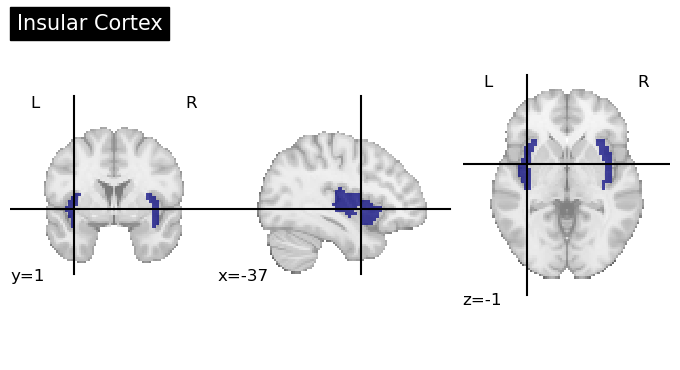

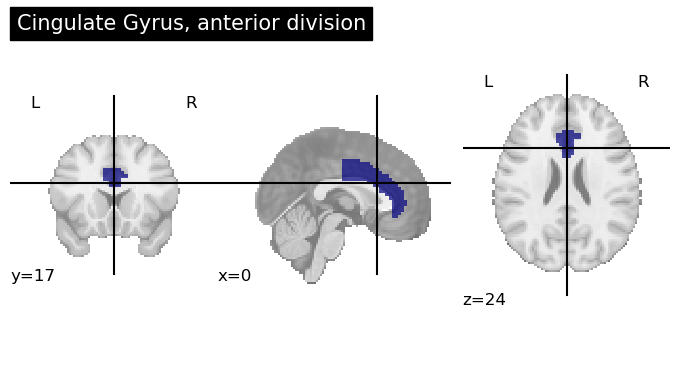

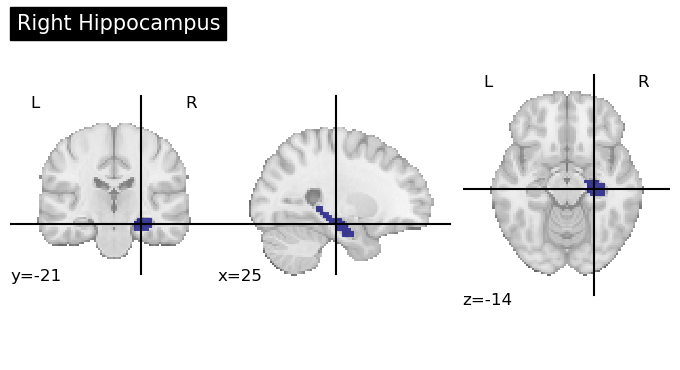

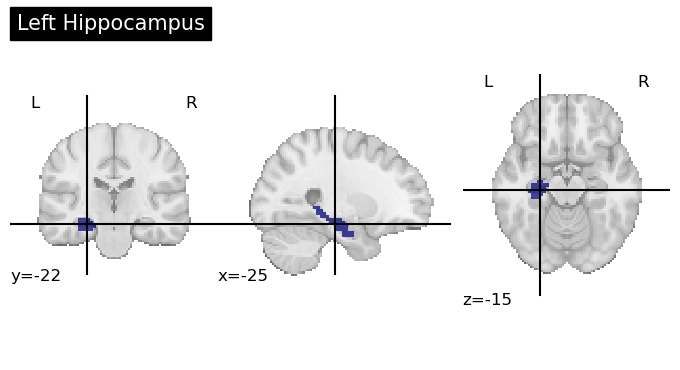

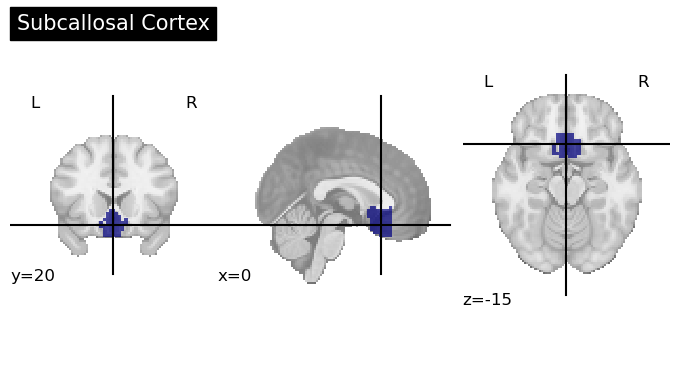

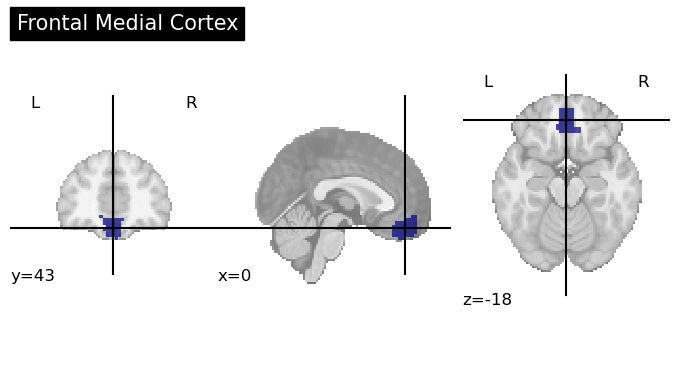

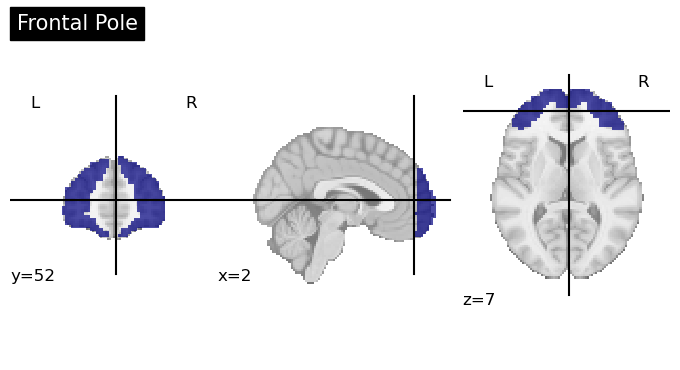

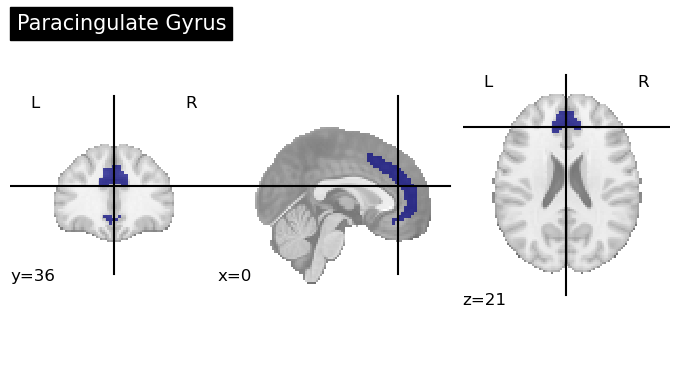

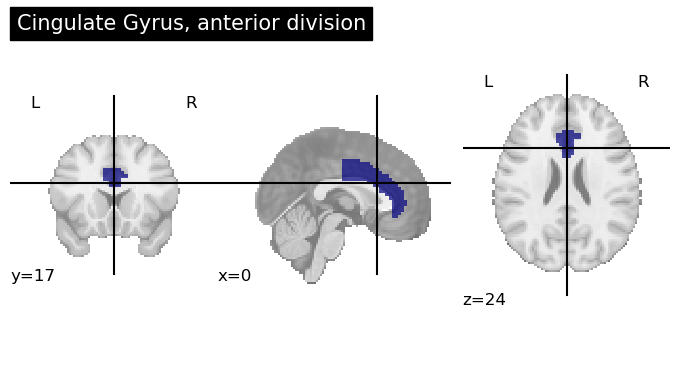

In [45]:
def create_and_plot_roi(label_of_interest, dataset, atlas_resampled):
    index_of_interest = dataset['labels'].index(label_of_interest)
    nii_data = atlas_resampled.get_fdata()
    roi_data = np.where(nii_data == index_of_interest, nii_data, 0)
    binarized_data = (roi_data > 0).astype(bool)
    
    roi_atlas = Nifti1Image(binarized_data, atlas_resampled.affine, header=atlas_resampled.header)
    plotting.plot_roi(roi_atlas, title=label_of_interest)
    
    return roi_atlas

#resample atlas map to data shape
atlas_sub_resampled = resample_to_img(source_img=dataset_ho_sub['maps'], target_img=space_defining_image, interpolation='nearest')
atlas_cort_resampled = resample_to_img(source_img=dataset_ho_cort['maps'], target_img=space_defining_image, interpolation='nearest')

right_amygdala_atlas = create_and_plot_roi('Right Amygdala', dataset_ho_sub, atlas_sub_resampled)
left_amygdala_atlas = create_and_plot_roi('Left Amygdala', dataset_ho_sub, atlas_sub_resampled)
insula_atlas = create_and_plot_roi('Insular Cortex', dataset_ho_cort, atlas_cort_resampled)
acc_atlas = create_and_plot_roi('Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)
right_hippocampus_atlas = create_and_plot_roi('Right Hippocampus', dataset_ho_sub, atlas_sub_resampled)
left_hippocampus_atlas = create_and_plot_roi('Left Hippocampus', dataset_ho_sub, atlas_sub_resampled)
vmpfc1_atlas = create_and_plot_roi('Subcallosal Cortex', dataset_ho_cort, atlas_cort_resampled)
vmpfc2_atlas = create_and_plot_roi('Frontal Medial Cortex', dataset_ho_cort, atlas_cort_resampled)
vmpfc3_atlas = create_and_plot_roi('Frontal Pole', dataset_ho_cort, atlas_cort_resampled)
vmpfc4_atlas = create_and_plot_roi('Paracingulate Gyrus', dataset_ho_cort, atlas_cort_resampled)
vmpfc5_atlas = create_and_plot_roi('Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array

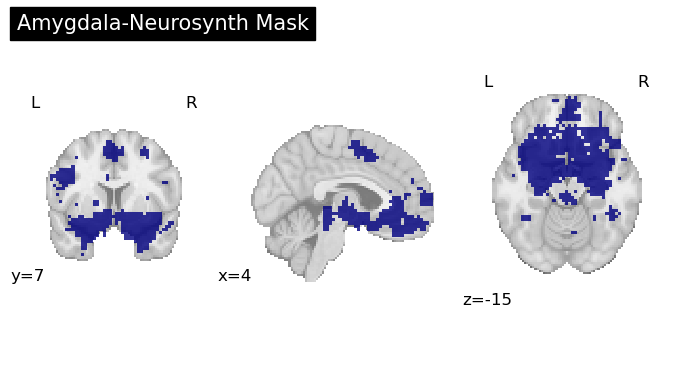

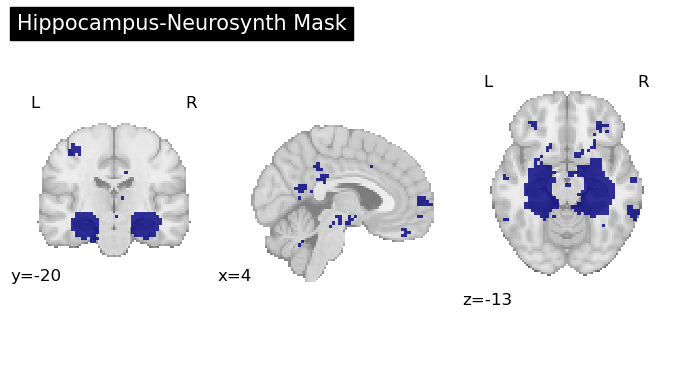

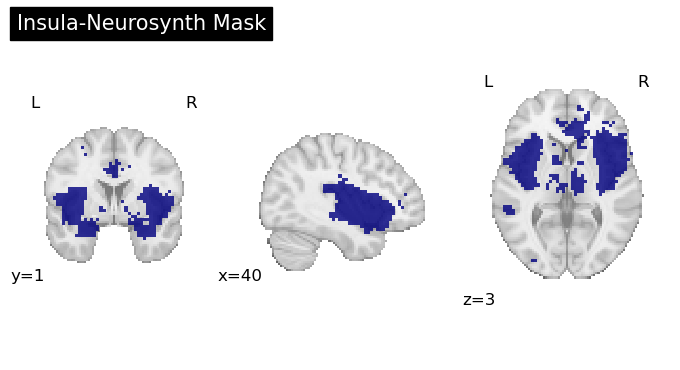

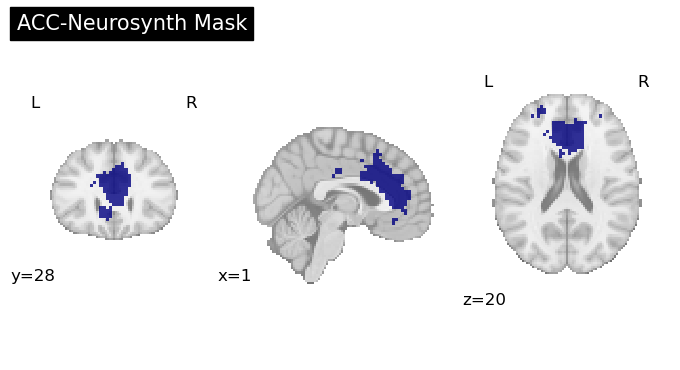

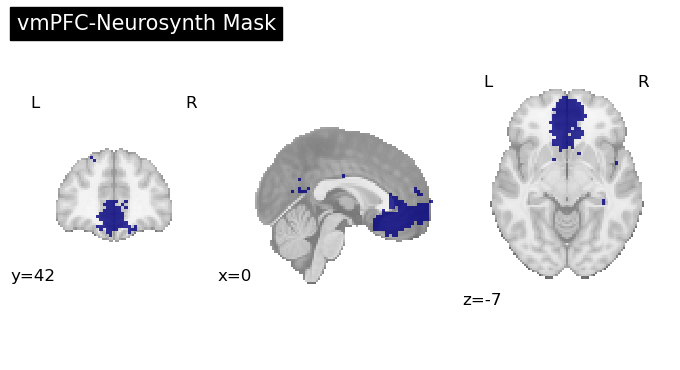

In [ ]:
# load in/plot neurosynth masks: 
# #import Neurosynth masks:
from nilearn.image import binarize_img

amygdala_func = load_img('/gscratch/fang/NARSAD/ROI/neurosynth-raw/amygdala.nii.gz')
amygdala_func = binarize_img(resample_to_img(source_img=amygdala_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(amygdala_func, draw_cross=False, alpha=0.8, title='Amygdala-Neurosynth Mask')

hippocampus_func = load_img('/gscratch/fang/NARSAD/ROI/neurosynth-raw/hippocampus.nii.gz')
hippocampus_func = binarize_img(resample_to_img(source_img=hippocampus_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(hippocampus_func, draw_cross=False, alpha=0.8, title='Hippocampus-Neurosynth Mask')

insula_func = load_img('/gscratch/fang/NARSAD/ROI/neurosynth-raw/insula.nii.gz')
insula_func = binarize_img(resample_to_img(source_img=insula_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(insula_func, draw_cross=False, alpha=0.8, title='Insula-Neurosynth Mask')

acc_func = load_img('/gscratch/fang/NARSAD/ROI/neurosynth-raw/acc.nii.gz')
acc_func = binarize_img(resample_to_img(source_img=acc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(acc_func, draw_cross=False, alpha=0.8, title='ACC-Neurosynth Mask')

vmpfc_func = load_img('/gscratch/fang/NARSAD/ROI/neurosynth-raw/vmpfc.nii.gz')
vmpfc_func = binarize_img(resample_to_img(source_img=vmpfc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(vmpfc_func, draw_cross=False, alpha=0.8, title='vmPFC-Neurosynth Mask')


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_761/976521645.py:11: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  amygdala = new_img_like(space_defining_image, amygdala)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_761/976521645.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  hippocampus = new_img_like(space_defining_image, hippocampus)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_761/976521645.py:26: UserWarning: Data array used to create a new image contains 

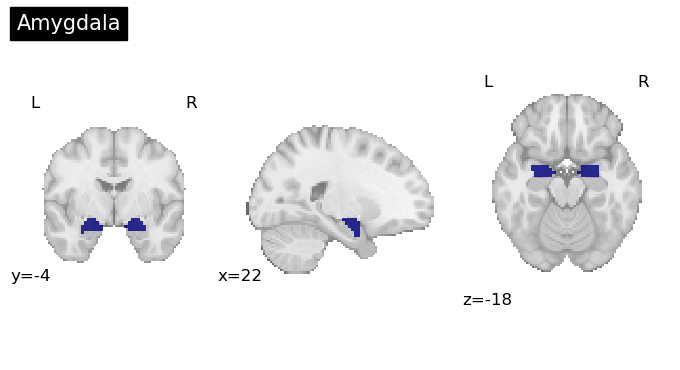

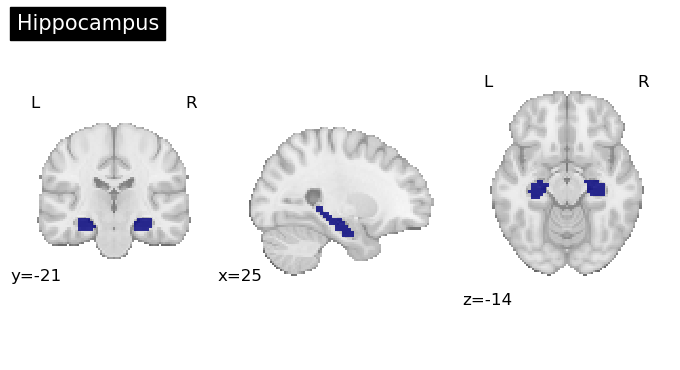

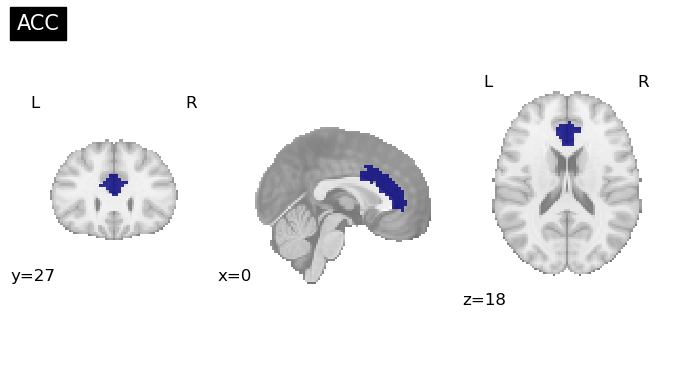

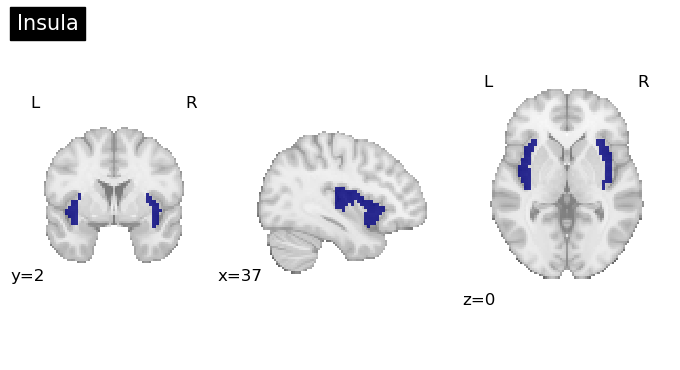

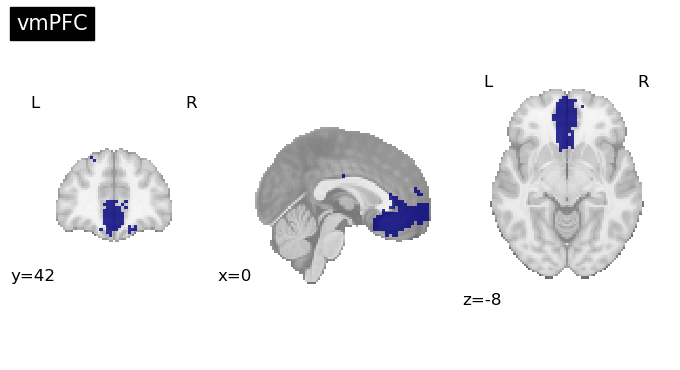

In [ ]:
path = '/gscratch/fang/NARSAD/ROI/anatomically-constrained'
os.chdir(path)

# anatomically-constraining functional ROIs + lateralizing 
from nilearn.image import new_img_like
right_amygdala = np.logical_and(amygdala_func.get_fdata(),right_amygdala_atlas.get_fdata())
right_amygdala = right_amygdala.astype(int)
left_amygdala = np.logical_and(amygdala_func.get_fdata(),left_amygdala_atlas.get_fdata())
left_amygdala = left_amygdala.astype(int)
amygdala = np.maximum.reduce([right_amygdala, left_amygdala])
amygdala = new_img_like(space_defining_image, amygdala)
plotting.plot_roi(amygdala, draw_cross=False, alpha=0.8, title="Amygdala")
nib.save(amygdala, 'amygdala.nii')

right_hippocampus = np.logical_and(hippocampus_func.get_fdata(),right_hippocampus_atlas.get_fdata())
right_hippocampus = right_hippocampus.astype(int)
left_hippocampus = np.logical_and(hippocampus_func.get_fdata(),left_hippocampus_atlas.get_fdata())
left_hippocampus = left_hippocampus.astype(int)
hippocampus = np.maximum.reduce([right_hippocampus, left_hippocampus])
hippocampus = new_img_like(space_defining_image, hippocampus)
plotting.plot_roi(hippocampus, draw_cross=False, alpha=0.8, title="Hippocampus")
nib.save(hippocampus, 'hippocampus.nii')

acc = np.logical_and(acc_func.get_fdata(),acc_atlas.get_fdata())
acc = acc.astype(int)
acc = new_img_like(space_defining_image, acc)
plotting.plot_roi(acc, draw_cross=False, alpha=0.8, title="ACC")
nib.save(acc, 'acc.nii')

insula = np.logical_and(insula_func.get_fdata(),insula_atlas.get_fdata())
insula = insula.astype(int)
insula = new_img_like(space_defining_image, insula)
plotting.plot_roi(insula, draw_cross=False, alpha=0.8, title="Insula")
nib.save(insula, 'insula.nii')

vmpfc1 = np.logical_and(vmpfc_func.get_fdata(),vmpfc1_atlas.get_fdata())
vmpfc1 = vmpfc1.astype(int)
vmpfc2 = np.logical_and(vmpfc_func.get_fdata(),vmpfc2_atlas.get_fdata())
vmpfc2 = vmpfc2.astype(int)
vmpfc3 = np.logical_and(vmpfc_func.get_fdata(),vmpfc3_atlas.get_fdata())
vmpfc3 = vmpfc3.astype(int)
vmpfc4 = np.logical_and(vmpfc_func.get_fdata(),vmpfc4_atlas.get_fdata())
vmpfc4 = vmpfc4.astype(int)
vmpfc5 = np.logical_and(vmpfc_func.get_fdata(),vmpfc5_atlas.get_fdata())
vmpfc5 = vmpfc5.astype(int)
vmpfc = np.maximum.reduce([vmpfc1, vmpfc2, vmpfc3, vmpfc4, vmpfc5])
vmpfc = new_img_like(space_defining_image, vmpfc)
plotting.plot_roi(vmpfc, draw_cross=False, alpha=0.8, title="vmPFC")
nib.save(vmpfc, 'vmpfc.nii')